In [28]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, ShortCircuit
from copy import deepcopy
from cb_models import AMPA, Synapse, NeuronalNetwork

# **Ignore overflow warnings**
import numpy as np
d = np.seterr(all="ignore")

In [55]:
neuron1 = HHModel()
neuron2 = HHModel()

burster = ShortCircuit([neuron1, neuron2])

neuron2.h.bA = 0

# Shift m and n for neuron 2
vshift = 20

# Shift m
neuron2.m.aVh = neuron1.m.aVh - vshift
neuron2.m.bVh = neuron1.m.bVh - vshift

# Shift n
neuron2.n.aVh = neuron1.n.aVh - vshift
neuron2.n.bVh = neuron1.n.bVh - vshift

# Scaling the time constants for m and n in neuron 2
t_scale1 = 15
t_scale2 = 30

# Scale the timescale for neuron 2 m variable
neuron2.m.aA = neuron1.m.aA / t_scale1
neuron2.m.bA = neuron1.m.bA / t_scale1

# Scale the timescale for neuron 2 n variable
neuron2.n.aA = neuron1.n.aA / t_scale2
neuron2.n.bA = neuron1.n.bA / t_scale2

# Turn off leak current for neuron 2 
neuron2.gl = 0

# Set reversal potential for neuron 2 sodium to calcium reversal
neuron2.Ena = 200

# Change maximal conductances of sodium and potassium for neuron 2
neuron2.gna = 1
neuron2.gk = 3

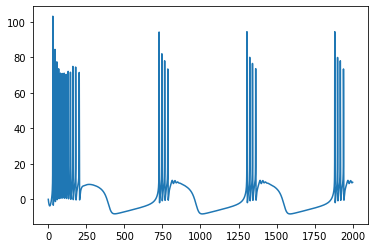

In [56]:
# Simulate HH short-circuit

T = 2000
t = (0, T)

I0 = -5
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = burster.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

In [57]:
burster2 = deepcopy(burster)

In [59]:
r = AMPA()
gsyn = 2
Esyn = -65
synapse = Synapse(gsyn, Esyn, r)

bursters = [burster, burster2]
syns = [[None, [synapse], None, None],
       [[synapse], None, None, None],
       [None, None, None, None],
       [None, None, None, None]]
network = NeuronalNetwork(bursters, syns=syns)

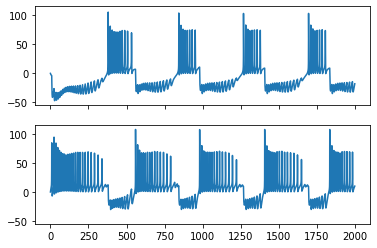

In [60]:
T = 2000
t = (0,T)

I0 = -5
Iapp = lambda t: [I0,0]

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(2, 1, sharey=True, sharex=True)
ax[0].plot(sol.t,sol.y[0])
ax[1].plot(sol.t,sol.y[7])
plt.show()

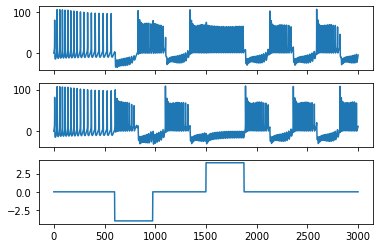

In [61]:
# Simulate HCO with transient input to burster 1
# Negative Iapp "turns on" HCO rhythm
# Positive Iapp doesn't "turn off" the rhythm?

def pulse(t, neg_start, pos_start, t_length, mag):
    I = (t>=neg_start)*mag - (t>=(neg_start+t_length))*mag - (t>=pos_start)*mag + (t>=pos_start+t_length)*mag
    return I

T = 3000
t = (0, T)

I0 = 0
pulse_mag = 4

def Iapp(t):
    neg_start = T / 5
    pos_start = T / 2
    t_length = T / 8
    return [I0 - pulse(t, neg_start, pos_start, t_length, pulse_mag), 0]

x0 = [0,0,0,0,0,0,0] *2 + [0] *2

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(sol.t, sol.y[0])
ax[1].plot(sol.t, sol.y[7])
ax[2].plot(np.arange(T), [Iapp(tn)[0] for tn in range(T)])
plt.show()

# Using Neuromodulators (conductances) to turn bursting on and off

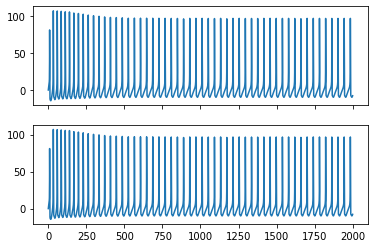

In [62]:
T = 2000
t = (0,T)

I0 = 0
Iapp = lambda t: [I0,0]

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(2, 1, sharey=True, sharex=True)
ax[0].plot(sol.t,sol.y[0])
ax[1].plot(sol.t,sol.y[7])
plt.show()

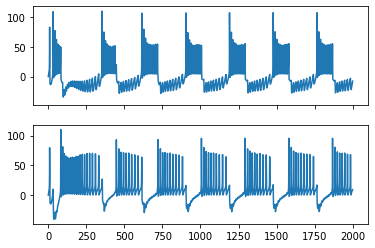

In [49]:
#burster.neurons[0].gk = 38  # was 36
burster.neurons[1].gna = 1.15   # was 1, SUPER sensitive

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(2, 1, sharey=True, sharex=True)
ax[0].plot(sol.t,sol.y[0])
ax[1].plot(sol.t,sol.y[7])
plt.show()

# De- and Re- Tuning

To "detune" change reversal potentials, "retune" by compensating with others

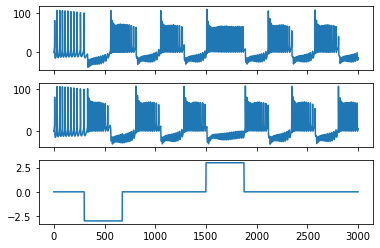

In [63]:
# reset
burster.neurons[0].gk = 36  # was 36
burster.neurons[0].Ena = 120  # was 120, 200 for slow
burster2.neurons[0].Ena = 120
burster.neurons[1].gna = 1

T = 3000
t = (0,T)

I0 = 0
pulse_mag = 3

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

def Iapp(t):
    neg_start = T / 10
    pos_start = T / 2
    t_length = T / 8
    return [I0 - pulse(t, neg_start, pos_start, t_length, pulse_mag), 0]

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(sol.t, sol.y[0])
ax[1].plot(sol.t, sol.y[7])
ax[2].plot(np.arange(T), [Iapp(tn)[0] for tn in range(T)])
plt.show()

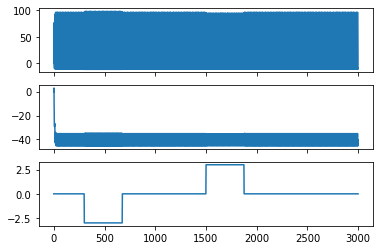

In [64]:
# Add noise to one reversal potential
#burster.neurons[0].Ena = 120  # was 120, 200 for slow
#burster2.neurons[0].Ena = 85

# Using perturb on burster 1 slow neuron...
burster.neurons[1].perturb(0.2) # 0.3 really messed it up, 0.2 might do 

T = 3000
t = (0,T)

I0 = 0
pulse_mag = 3

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

def Iapp(t):
    neg_start = T / 10
    pos_start = T / 2
    t_length = T / 8
    return [I0 - pulse(t, neg_start, pos_start, t_length, pulse_mag), 0]

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(sol.t, sol.y[0])
ax[1].plot(sol.t, sol.y[7])
ax[2].plot(np.arange(T), [Iapp(tn)[0] for tn in range(T)])
plt.show()

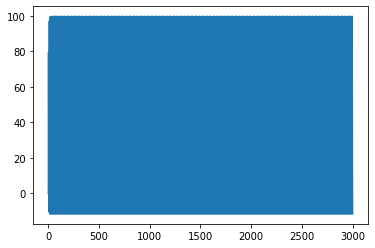

In [65]:
# Check burster 1
I0 = -5
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = burster.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

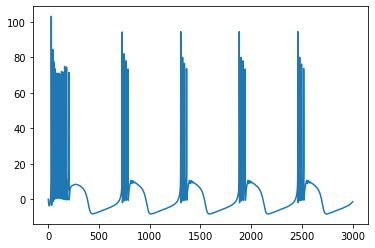

In [66]:
# Check burster 2
I0 = -5
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = burster2.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

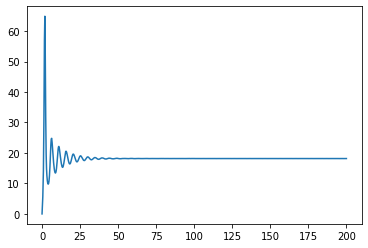

In [67]:
# Check Burster 1 Slow Neuron - issue here!
I0_single = 8
iapp1 = lambda t: I0_single

T_s = 200
t_s = (0, T_s)
x01 = [0,0,0,0]

sol1 = burster.neurons[1].simulate(t_s, x01, iapp1)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.show()

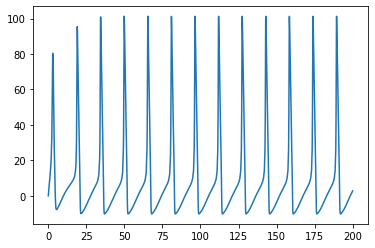

In [69]:
# Check Burster 1 Fast Neuron
I0_single = 8
iapp1 = lambda t: I0_single

T_s = 200
t_s = (0, T_s)
x01 = [0,0,0,0]

sol1 = burster.neurons[0].simulate(t_s, x01, iapp1)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.show()

# Retuning
Most systematic way to go about this? Is it "cheating" to check current values?

In [73]:
burster.neurons[1].Ena

128.99401669443583

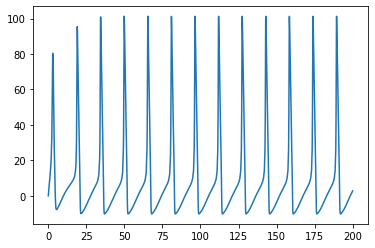

In [74]:
burster.neurons[1].Ena = 200

I0_single = 8
iapp1 = lambda t: I0_single

T_s = 200
t_s = (0, T_s)
x01 = [0,0,0,0]

sol1 = burster2.neurons[0].simulate(t_s, x01, iapp1)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.show()

In [ ]:
# Recovery?
T = 3000
t = (0,T)

I0 = 0
pulse_mag = 3

x0 = [0,0,0,0,0,0,0] * 2 + [0] * 2

def Iapp(t):
    neg_start = T / 10
    pos_start = T / 2
    t_length = T / 8
    return [I0 - pulse(t, neg_start, pos_start, t_length, pulse_mag), 0]

sol = network.simulate(t, x0, Iapp)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(sol.t, sol.y[0])
ax[1].plot(sol.t, sol.y[7])
ax[2].plot(np.arange(T), [Iapp(tn)[0] for tn in range(T)])
plt.show()

In [76]:
# read paper to use other negative conductances of slow neuron to turn stuff on / off (calcium?)
# use HH perturb function instead of detuning by hand